# 15.Proje-FlowerClassification

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/04-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/15-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

In [2]:
pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import pandas as pd
from scipy import stats
import numpy as np
import glob
import tensorflow as tf
import random
import time
import copy
from operator import itemgetter

from collections import OrderedDict, namedtuple
import joblib

import logging
import sys

import PIL
import cv2
import albumentations as A
import io
import IPython.display as display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim

import torchvision
# from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection

import warnings
warnings.filterwarnings("ignore");

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Çıkarılan Dosyaları birleştirelim

In [5]:
train_files = glob.glob('../input/tpu-getting-started/*224/train/*.tfrec')
val_files = glob.glob('../input/tpu-getting-started/*224/val/*.tfrec')
test_files = glob.glob('../input/tpu-getting-started/*224/test/*.tfrec')

In [6]:
def parse_tfrec_data(files, test=False):
    if not test: 
        feature_description = {
            'class': tf.io.FixedLenFeature([], tf.int64),
            'id': tf.io.FixedLenFeature([], tf.string),
            'image': tf.io.FixedLenFeature([], tf.string),
        }
    else:
        feature_description = {
        'id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    parse_image_f = lambda x: tf.io.parse_single_example(x, feature_description)

    ids = []
    images = []
    if not test:
        cl = []

    for i in tqdm(files):
        image_dataset = tf.data.TFRecordDataset(i)
        image_dataset = image_dataset.map(parse_image_f)

        ids_ = [str(id_features['id'].numpy())[2:-1] for id_features in image_dataset] # [2:-1] is done to remove b' from 1st and 'from last in train id names
        ids = ids + ids_

        images_ = [image_features['image'].numpy() for image_features in image_dataset]
        images = images + images_

        if not test:
                cl_ = [int(class_features['class'].numpy()) for class_features in image_dataset]
                cl = cl + cl_
    if test:
        return ids, images
    else:
        return ids, cl, images

Bu kod, TensorFlow kütüphanesi kullanılarak TFRecord formatındaki veri dosyalarını işlemek için yazılmış bir fonksiyon içerir. TFRecord formatı, büyük veri setlerini daha hızlı ve verimli bir şekilde okumak ve yazmak için kullanılan bir veri formatıdır. Genellikle TensorFlow modellerinin eğitimi için tercih edilir.

Fonksiyonun genel amacı, bir veya birden çok TFRecord dosyasını almak, bu dosyaları işlemek ve içerdikleri özellikleri çıkarmaktır. Bu özellikler, genellikle eğitimde kullanılacak olan etiketler (`class`), örnek tanımlayıcıları (`id`) ve görüntü verilerini (`image`) içerir.

Kodun ana bileşenleri şunlardır:

1. `parse_tfrec_data` fonksiyonu: Bu fonksiyon, TFRecord dosyalarını işlemek için kullanılır. `files` parametresi, işlem yapılacak TFRecord dosyalarının listesini içerir. `test` parametresi ise fonksiyonun eğitim veya test verisi için kullanılıp kullanılmadığını belirler.

2. `feature_description` sözlüğü: Bu sözlük, TFRecord dosyasındaki her özelliğin (class, id, image) veri tipini ve şeklini tanımlar.

3. `parse_image_f` fonksiyonu: Bu iç fonksiyon, bir TFRecord öğesini (`tf.io.parse_single_example` kullanılarak) işlemek için kullanılır. Her özelliği `feature_description` sözlüğüne göre çözümler.

4. `ids`, `cl` ve `images` listeleri: Bu listeler, TFRecord dosyalarından çıkarılan özelliklerin (id, class, image) depolandığı listelerdir.

5. Dönen değer: Fonksiyon, eğer `test` parametresi `True` ise `ids` ve `images` listelerini, `False` ise `ids`, `cl` ve `images` listelerini içeren bir tuple döndürür.

Fonksiyonun çalışma akışı, her bir TFRecord dosyasını açmak, içeriğini `parse_image_f` fonksiyonu aracılığıyla işlemek ve ardından `ids`, `cl` ve `images` listelerine eklemektir. Eğitim verisi için, `class` özelliği de çıkarılır ve `cl` listesine eklenir. Test verisi için sadece `id` ve `image` özellikleri alınır.

In [7]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [8]:
from tqdm import tqdm

In [9]:
train_ids, train_cl, train_images = parse_tfrec_data(train_files)
val_ids, val_cl, val_images = parse_tfrec_data(val_files)
test_ids, test_images = parse_tfrec_data(test_files, test=True)

100%|██████████| 16/16 [00:06<00:00,  2.64it/s]


Bu kod, üç farklı veri kümesinin (eğitim, doğrulama/validasyon ve test) TFRecord formatındaki dosyalarını işlemek için `parse_tfrec_data` fonksiyonunu kullanır. İşlem sonucunda, her bir veri kümesi için özel olarak belirtilmiş değişkenlere (ids, cl, images) atanan değerlere sahip oluruz.

1. `train_files`: Eğitim veri kümesinin TFRecord dosyalarının listesi.
2. `val_files`: Doğrulama/validasyon veri kümesinin TFRecord dosyalarının listesi.
3. `test_files`: Test veri kümesinin TFRecord dosyalarının listesi.

Bu kod, `parse_tfrec_data` fonksiyonunu kullanarak her bir veri kümesinin TFRecord dosyalarını işler ve aşağıdaki değişkenlere atar:

- `train_ids`, `train_cl`, `train_images`: Eğitim veri kümesinin özelliklerini (id, class, image) içeren değişkenler.
- `val_ids`, `val_cl`, `val_images`: Doğrulama/validasyon veri kümesinin özelliklerini içeren değişkenler.
- `test_ids`, `test_images`: Test veri kümesinin özelliklerini içeren değişkenler.

Bu örnekte, eğitim ve doğrulama/validasyon veri kümesi için `class` özelliği (`train_cl` ve `val_cl`) çıkarılırken, test veri kümesi için sadece `id` ve `image` özellikleri (`test_ids` ve `test_images`) alınır. Bu, genellikle eğitim sürecinde modelin performansını izlemek ve hiperparametre ayarlamak için bir doğrulama/validasyon veri kümesi kullanmanın yaygın bir uygulamasıdır.

In [10]:
train_ids, train_cl, train_images = train_ids + val_ids[:1500], train_cl + val_cl[:1500], train_images + val_images[:1500]
val_ids, val_cl, val_images = val_ids[1500:], val_cl[1500:], val_images[1500:]

Bu kodun amacı, başlangıçta ayrı olan eğitim (`train`) ve doğrulama (`val`) veri kümelerini birleştirmek ve ardından bu birleşik veri kümesinden belirli bir kısmını eğitim veri kümesine, geri kalanını ise doğrulama veri kümesine ayırmaktır.

1. İlk satır, eğitim veri kümesine, doğrulama veri kümesinin başından (ilk 1500 öğe) alınan öğeleri ekler. Böylece eğitim veri kümesi genişler.

2. İkinci satır, doğrulama veri kümesinden başından (ilk 1500 öğe) alınanları çıkararak geriye kalan kısmını doğrulama veri kümesi olarak bırakır. Yani, doğrulama veri kümesi daralır.

Bu işlem, genellikle model eğitimi sırasında bir doğrulama (validasyon) setini ayrı tutmak ve eğitim sırasında modelin performansını izlemek için kullanılır. Bu sayede, eğitim veri kümesi genişletilirken, doğrulama veri kümesi bağımsız bir doğrulama seti olarak kullanılmaya devam eder.

In [11]:
# eğitim test ve doğrulamada kaç veri var diye bakıyoruz
print(f'''# train images: {len(train_ids)}
# val images: {len(val_ids)}
# test images {len(test_ids)}''' )

# train images: 14253
# val images: 2212
# test images 7382


4ec4282a1
73


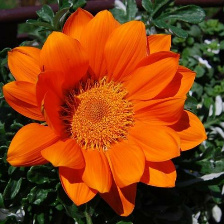

In [12]:
print(train_ids[33])
print(train_cl[33])
sample_img = PIL.Image.open(io.BytesIO(train_images[0]))
sample_img

Bu satırlar, eğitim veri kümesinin ilk örneğinin görüntüsünü bir PIL (Python Imaging Library) görüntü nesnesine yükler ve bu görüntüyü ekrana basar. io.BytesIO kullanılarak train_images[0] verisi (byte cinsinden bir görüntü) bir bellek akışı nesnesine çevrilir ve ardından PIL.Image.open ile bu akıştan bir görüntü nesnesi oluşturulur.

Bu kodun çalışabilmesi için, PIL ve io modüllerini import ettiğinizden emin olmalısınız. Ayrıca, bu kodun çalışması için eğitim veri kümesinde en az bir örnek bulunmalıdır.

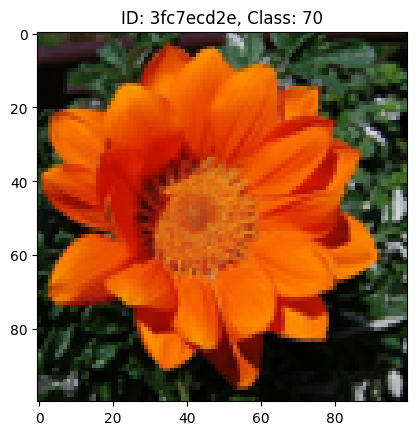

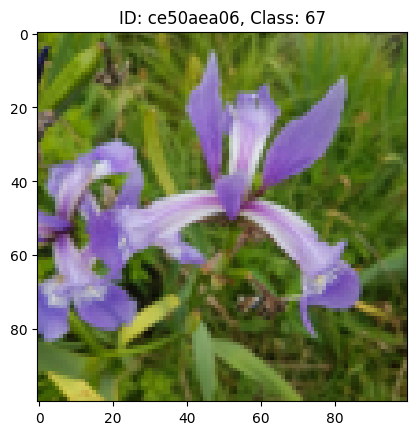

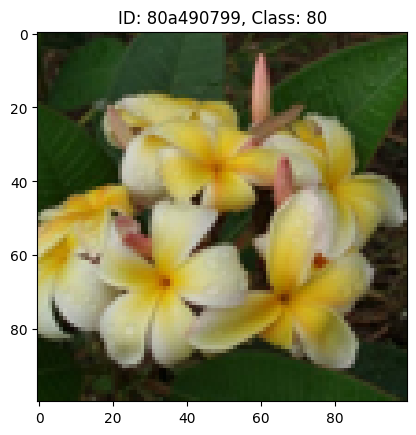

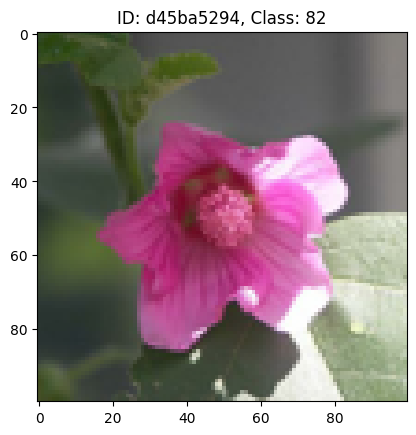

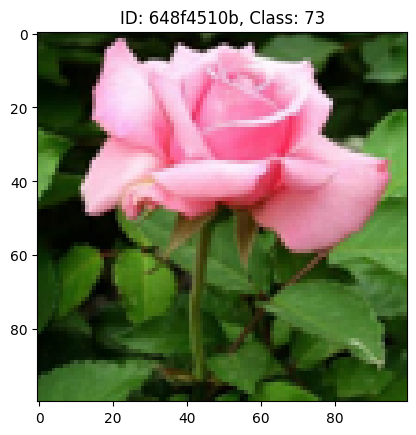

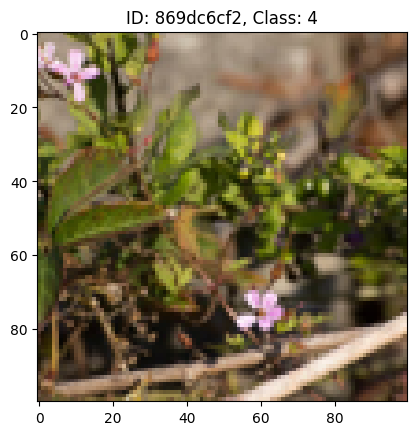

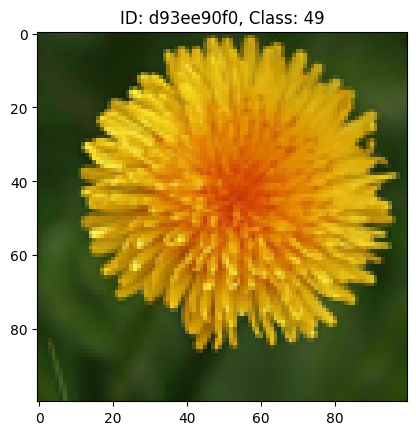

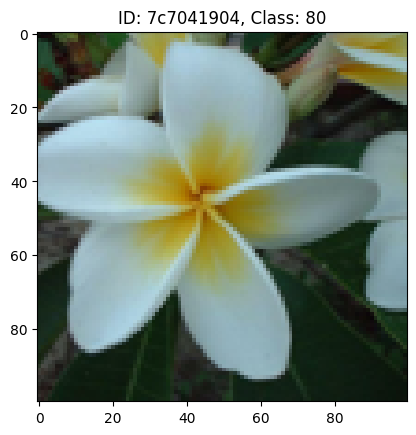

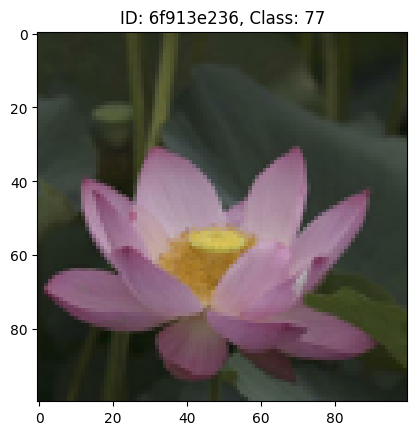

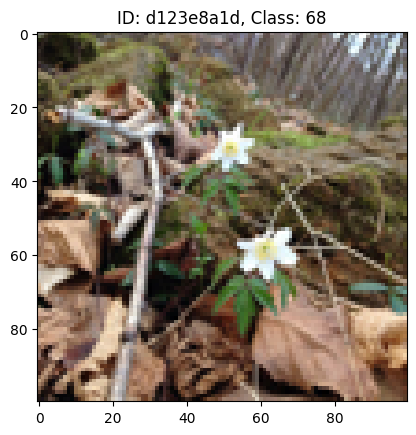

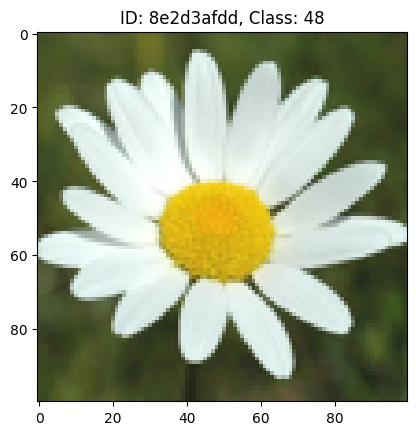

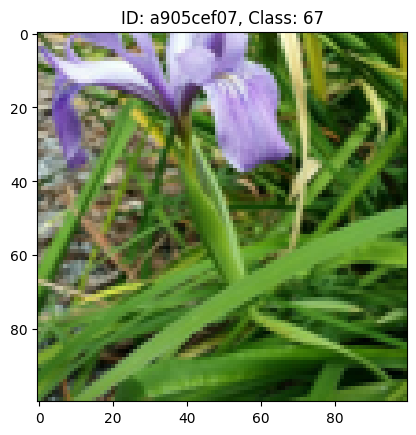

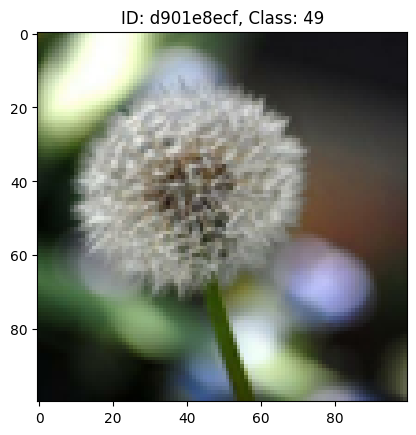

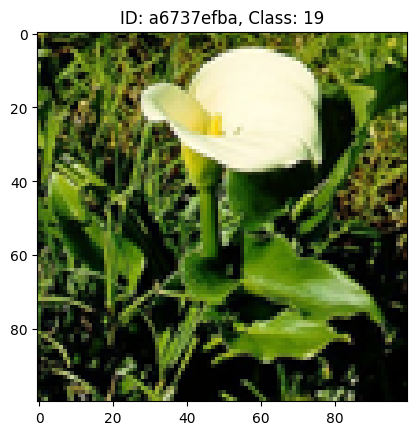

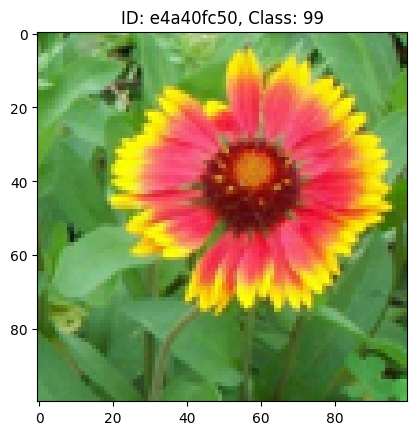

In [13]:
import matplotlib.pyplot as plt

# Eğitim veri kümesinden ilk 15 örnek alınır
sample_images = train_images[:15]

# Her bir resmi boyutlandırarak bastırma
for i, image_data in enumerate(sample_images):
    image = PIL.Image.open(io.BytesIO(image_data))
    resized_image = image.resize((100, 100))
    
    plt.imshow(resized_image)
    plt.title(f"ID: {train_ids[i]}, Class: {train_cl[i]}")
    plt.show()

In [14]:
class FlowerDataset(Dataset):
    
    def __init__(self, ids, images, cl, transforms, test=False):
        
        self.ids = ids
        self.images = images
        if not test:
            self.cl = cl
        self.transforms = transforms
        self.is_test = test
    
    def __len__(self):
        return len(self.ids)
        
    def __getitem__(self, idx):
        
        img = self.images[idx]
        img = PIL.Image.open(io.BytesIO(img))
        img = np.array(img)
        img = self.transforms(image=img)['image']
        
        if self.is_test:
            return img, -1, self.ids[idx]
        return img, int(self.cl[idx]), self.ids[idx]
     

Bu kod, PyTorch'ta kullanılmak üzere özel bir veri kümesi sınıfı (`FlowerDataset`) tanımlar. Bu sınıf, çiçek veri setiyle çalışmayı amaçlar ve belirli bir formattaki veri setini PyTorch modelinin eğitimi veya değerlendirmesi için kullanılabilir hale getirir.

İşlevleri:

- `__init__`: Sınıfın başlatıcı metodu. Bu metot, veri kümesi oluşturulurken gerekli olan parametreleri alır. Bu parametreler arasında öğelerin (örneklerin) IDs (`ids`), görüntülerin (`images`), sınıfların (`cl`), dönüşümlerin (`transforms`) ve veri kümesinin test veri kümesi olup olmadığını belirten bir bayrak (`test`) bulunmaktadır.

- `__len__`: Bu metot, veri kümesindeki öğe sayısını (uzunluğunu) döndürür.

- `__getitem__`: Bu metot, belirli bir indis (`idx`) için veri kümesinden bir öğeyi döndürür. Bu genellikle eğitim veya değerlendirme sırasında kullanılır. Veri seti içindeki bir öğe, belirtilen dönüşümler (`transforms`) uygulanarak PyTorch tensor formatına çevrilir.

İlk bakışta, bu sınıf, çiçek veri setinin görüntülerini ve ilgili etiketlerini PyTorch modeline beslemek için kullanılacak bir veri kümesi sınıfını temsil eder. Eğitim sırasında (`test=False`), her bir öğenin sınıf etiketi (`cl`) ile birlikte görüntüsü ve ID'si döndürülür. Test sırasında (`test=True`), sadece görüntü ve ID döndürülür; sınıf etiketi `-1` olarak ayarlanır.

In [15]:
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([A.HorizontalFlip(p=0.3),
                           A.VerticalFlip(p=0.3),
                           A.ShiftScaleRotate(p=0.1),
                           A.OneOf([A.RandomShadow(p=1.), A.RandomSunFlare(src_radius=100, p=1.),], p=0.25),
                            A.RandomFog(p=0.1),
                              A.Blur(blur_limit=3, p=0.2),
                           A.GaussNoise(var_limit=200. ,p=0.1),
                           A.RandomBrightness(limit=0.2, p=0.1),
                           A.CLAHE(clip_limit=3, p=0.1),
                            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                           ToTensorV2()
                              
    ])

val_transforms = A.Compose([A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2() ])
test_transforms = A.Compose([A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()])

Bu kod, `albumentations` kütüphanesini kullanarak görüntü veri artırma (data augmentation) işlemlerini tanımlayan bir dizi dönüşümü içerir. Ayrıca, bu dönüşümleri PyTorch tensor formatına dönüştürmek için `ToTensorV2()` kullanılır.

İşte kullanılan dönüşümler ve açıklamaları:

### `train_transforms` (Eğitim Dönüşümleri):
- `HorizontalFlip`: Görüntüyü yatay eksende rastgele çevirme (yatay çevirme).
- `VerticalFlip`: Görüntüyü dikey eksende rastgele çevirme (dikey çevirme).
- `ShiftScaleRotate`: Görüntüyü rastgele kaydırma, ölçekleme ve döndürme.
- `OneOf`: Bir dizi içinden rastgele bir dönüşüm uygulama (gölgelendirme veya güneş ışığı efekti).
- `RandomFog`: Görüntüye rastgele sis efekti uygulama.
- `Blur`: Görüntüye belirli bir sınıra kadar rastgele bulanıklık uygulama.
- `GaussNoise`: Görüntüye gauss gürültüsü ekleyerek rastgele parlaklık uygulama.
- `RandomBrightness`: Görüntüye rastgele parlaklık ayarı uygulama.
- `CLAHE`: Görüntüye kontrast sınırlı adaptif histogram eşitleme uygulama.
- `Normalize`: Görüntüyü normalize etme (ortalama ve standart sapma kullanılarak).

### `val_transforms` (Doğrulama Dönüşümleri):
- Sadece normalize işlemi uygulanır. Eğitim sırasında kullanılan karmaşık artırma işlemleri doğrulama sırasında genellikle kullanılmaz.

### `test_transforms` (Test Dönüşümleri):
- Sadece normalize işlemi uygulanır. Test sırasında modelin performansını değerlendirmek için kullanılır ve genellikle artırma işlemleri içermez.

Bu dönüşümler, özellikle görüntü sınıflandırma modeli eğitimi için kullanılabilir. Artırma işlemleri, modelin çeşitli perspektiflerden öğrenmesine ve daha genelleştirilebilir olmasına yardımcı olabilir.

In [16]:
train_dataset = FlowerDataset(train_ids, train_images, train_cl, transforms=train_transforms)
val_dataset = FlowerDataset(val_ids, val_images, val_cl, transforms=val_transforms)
test_dataset = FlowerDataset(test_ids, test_images, None, transforms=test_transforms, test=True)

train_loader = DataLoader(train_dataset, batch_size=50, num_workers=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=50, num_workers=4,  shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=50, num_workers=4,  shuffle=True, pin_memory=True)

Bu kod, PyTorch kullanılarak çiçek veri setini işlemek üzere veri yükleyicilerini (data loader) oluşturan bir dizi işlemi içerir. Aşağıda kodun anlamını ve amacını açıklayan detaylar:

1. **`FlowerDataset` Sınıfı:**
   - `train_dataset`, `val_dataset`, ve `test_dataset` değişkenleri, `FlowerDataset` sınıfından örneklerdir. Bu sınıf, veri kümesini PyTorch modeline uygun hale getirmek için kullanılır. Eğitim, doğrulama ve test veri kümesi için ayrı ayrı oluşturulur.
   - `train_ids`, `train_images`, `train_cl` gibi parametreler, veri kümesinin giriş verileridir. `transforms` ise bu verilere uygulanacak olan görüntü dönüşümleridir.

2. **`DataLoader` Oluşturma:**
   - `DataLoader` sınıfı, PyTorch'ta toplu işlemleri kolaylaştırmak için kullanılır. Bu sınıf, veri kümesinden belirli sayıda örneği alarak ve isteğe bağlı olarak karıştırarak modelin eğitimini veya değerlendirmesini sağlar.
   - `batch_size`: Her bir toplu işlemin boyutunu belirtir. Örneğin, `batch_size=50` ise, her toplu işlemde 50 örnek işlenir.
   - `num_workers`: Veri yükleyicinin paralel işleme için kullanabileceği işçi sayısını belirtir.
   - `shuffle`: `True` olarak ayarlandığında, her geçişte veriler karıştırılır; bu, modelin daha iyi genelleme yapmasına yardımcı olabilir.
   - `pin_memory`: `True` olarak ayarlandığında, toplu işlemler GPU belleğine daha hızlı taşınabilir.

Bu kodun genel amacı, çiçek veri setini eğitim, doğrulama ve test için uygun PyTorch veri kümesi ve veri yükleyicilerine dönüştürmektir. Bu şekilde, PyTorch modelinizi eğitmek veya değerlendirmek için hazır bir veri akışı oluşturabilirsiniz.

In [17]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

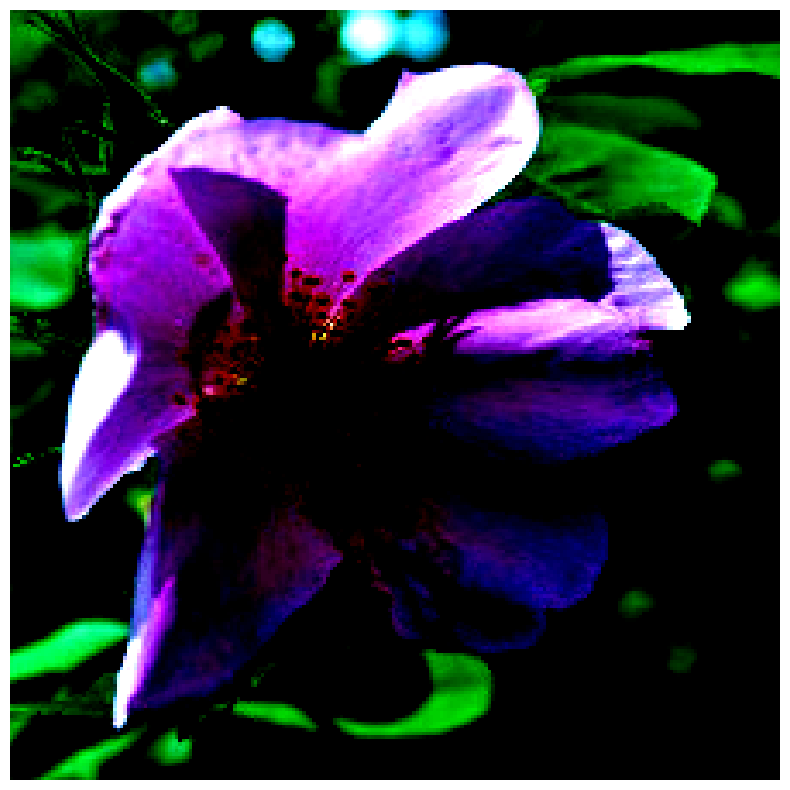

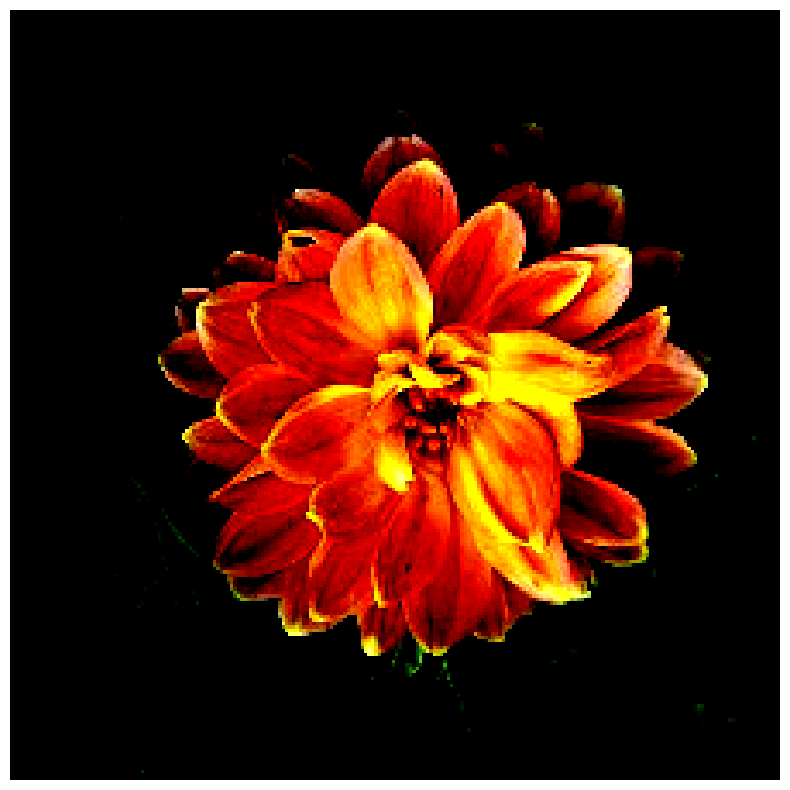

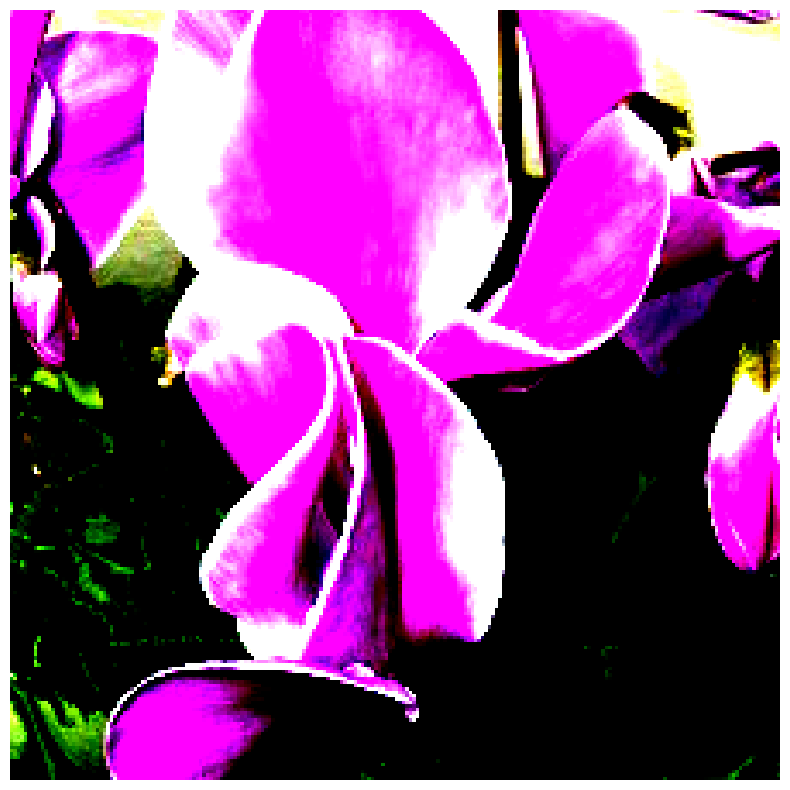

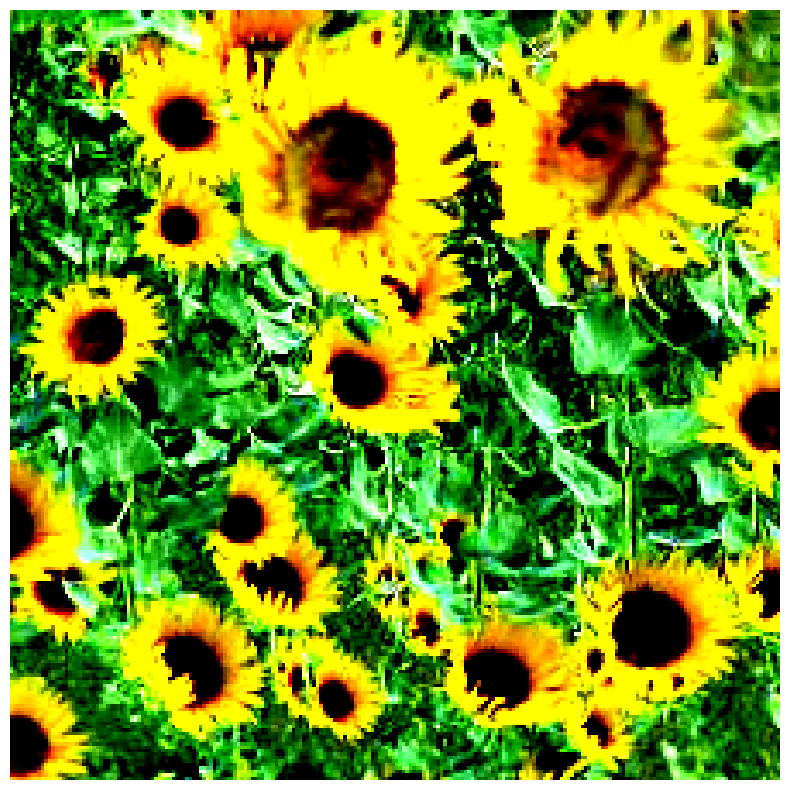

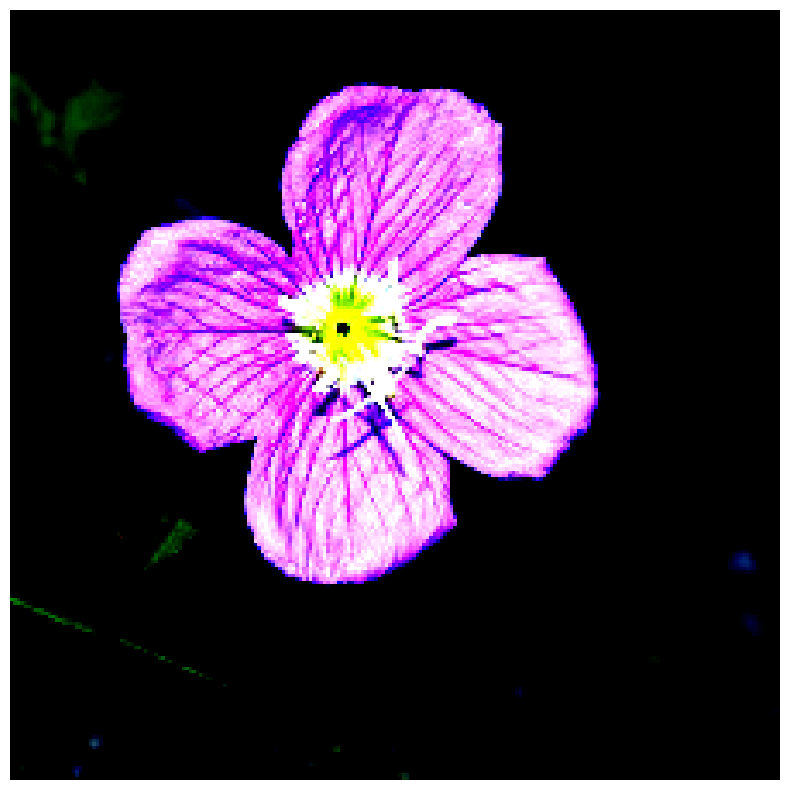

In [18]:
train_iter = iter(train_loader)
img = next(train_iter)
for img2show in img[0][:5].permute(0, 2, 3, 1):
    visualize(img2show.numpy())

Bu kod parçası, PyTorch'un DataLoader ve iteratörlerini kullanarak eğitim veri kümesinden bir toplu işlem alır ve bu toplu işlemdeki ilk 10 örneği görselleştirmek amacıyla `visualize` fonksiyonunu kullanır. Bu tür bir görselleştirme, eğitim veri kümesinin örneklere nasıl dönüştürüldüğünü ve artırılmış görüntülerin nasıl göründüğünü anlamak için kullanılabilir. Şimdi bu kodun adım adım nasıl çalıştığını anlayalım:

1. **`train_iter = iter(train_loader)`:** `train_loader` adlı eğitim veri kümesinin bir iteratörünü oluşturur. Bu, eğitim veri kümesinden öğeleri çekmek için `next` fonksiyonunu kullanmak üzere bir iteratöre sahip olmanızı sağlar.

2. **`img = next(train_iter)`:** `train_loader` iteratöründen bir sonraki toplu işlemi (`img`) alır. `img` bir tuple olarak döner ve içinde görüntüler ve ilgili etiketler bulunabilir.

3. **`for img2show in img[0][:10].permute(0, 2, 3, 1):`:** Bu döngü, toplu işlem içindeki ilk 10 örneği seçer (`img[0][:10]`), kanalların yerini düzenlemek için `permute` fonksiyonunu kullanır (çünkü Matplotlib, renk kanallarını son eksen olarak bekler) ve ardından her bir örneği `visualize` fonksiyonu aracılığıyla görselleştirmek için kullanır.

4. **`visualize(img2show.numpy())`:** `visualize` fonksiyonu, PyTorch tensorını Matplotlib tarafından görüntülenebilecek bir Numpy dizisine dönüştürür ve bu görüntüyü ekranda gösterir.

Bu tür bir kod, eğitim veri kümesini incelemek ve veri artırma işlemlerinin nasıl uygulandığını anlamak için kullanılabilir. Görüntülerin nasıl değiştiğini ve eğitim sırasında modele nasıl sunulduğunu görselleştirerek, modelin öğrenme sürecini anlama ve hata analizi yapma sürecinizi kolaylaştırabilirsiniz.

## Modelleme

In [19]:
model = torchvision.models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 217MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Bu kod, PyTorch kütüphanesinde bulunan `torchvision` modülü içindeki önceden eğitilmiş (pretrained) bir ResNet-50 modelini indirip yaratır. İlgili satırları detaylandıralım:

1. `torchvision.models.resnet50(pretrained=True)`: Bu satır, ResNet-50 modelini oluşturur ve önceden eğitilmiş ağırlıkları (pretrained weights) kullanarak modeli başlatır. ResNet-50, 50 katman içeren bir derin öğrenme mimarisidir ve özellikle görüntü sınıflandırma görevlerinde etkilidir.

2. `model`: Elde edilen model, `model` değişkenine atanır. Bu değişken artık bir ResNet-50 modelini temsil eder ve eğitim verileri üzerinde fine-tuning veya başka görevlerde kullanılabilir.

Bu tür bir önceden eğitilmiş model, genellikle büyük bir görüntü veri kümesi üzerinde eğitildiği için genel özellik çıkarma veya transfer öğrenme görevlerinde kullanılır. Bu modeller, özellikle Computer Vision alanında yaygın olarak kullanılan derin öğrenme modellerindendir ve birçok uygulama için iyi bir başlangıç noktası sağlar.

In [20]:
for n, p in model.named_parameters():
    if n.split('.')[0] not in ['layer4']:
        p.requires_grad = False
model.fc = nn.Linear(2048, 104)

Bu kod, önceden eğitilmiş bir ResNet modelinin belirli parametrelerini (ağırlıklarını) dondurma (gradient hesaplamayı kapatma) ve ardından bu modele yeni bir tam bağlantılı (fully connected) katman ekleyerek sınıf sayısını değiştirme işlemini gerçekleştiriyor. Şimdi detaylı bir şekilde açıklayalım:

1. `for n, p in model.named_parameters():`: Modelin tüm parametrelerini (weights) adlarıyla birlikte dolaşan bir döngü başlatılır.

2. `if n.split('.')[0] not in ['layer4']: p.requires_grad = False`: Modelin isim uzayını kullanarak, 'layer4' isimli parametrelerin gradyan hesaplamasını kapatır. Yani, bu kod, 'layer4' katmanının ötesindeki tüm parametrelerin (evrişim katmanları dahil) eğitilmesini durdurur.

3. `model.fc = nn.Linear(2048, 104)`: Modelin tam bağlantılı (fully connected) çıkış katmanını değiştirir. Önceden eğitilmiş ResNet modeli, 2048 özellik çıkışına sahip bir tam bağlantılı katmanla sona eriyordu (`fc`: `Linear(in_features=2048, out_features=1000)`). Ancak siz, bu modele kendi veri kümenizdeki sınıf sayısına uygun olarak yeni bir çıkış katmanı ekliyorsunuz. Örneğin, `nn.Linear(2048, 104)` ifadesi, 2048 giriş özelliği ve 104 çıkış sınıfıyla yeni bir tam bağlantılı katman oluşturur. Bu, modelin sınıflandırma göreviniz için kullanılabilecek bir hale getirilmesini sağlar.

In [21]:
for k, p in model.named_parameters():
    if p.requires_grad:
        print(k)

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.conv3.weight
layer4.0.bn3.weight
layer4.0.bn3.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.1.conv3.weight
layer4.1.bn3.weight
layer4.1.bn3.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.weight
fc.bias


Bu kod, modelin tüm parametrelerini isimleriyle birlikte kontrol eder ve `requires_grad` özelliği `True` olan parametreleri ekrana yazdırır. `model.named_parameters()` fonksiyonu, modelin tüm öğrenilebilir parametrelerini döndürür ve her bir parametre çifti, parametrenin adı (k) ve kendisi (p) ile birlikte verilir. `requires_grad` özelliği, bu parametrenin eğitilebilir olup olmadığını belirtir.

Bu tür bir kontrol, özellikle transfer öğrenme veya özel eğitim senaryolarında belirli katmanları veya parametreleri dondurmak veya eğitilebilir yapmak için kullanılabilir. Bu örnekte, ekrana yazdırılanlar `requires_grad` özelliği `True` olan, yani eğitim sırasında güncellenen parametrelerdir.

Bu çıktılar, modelin öğrenilebilir parametrelerini (weights ve biases) temsil eden isimleri içerir. Her bir satırda bir parametre bulunmaktadır ve bu parametreler, modelin farklı katmanlarına ve alt katmanlarına aittir.

Örneğin, `layer4.0.conv1.weight` ifadesi, modelin `layer4` katmanının ilk alt katmanındaki (`0` alt katmanı) `conv1` adlı Convolutional (Evrişim) katmanının ağırlıklarını temsil eder. Benzer şekilde, `layer4.0.bn1.weight` ve `layer4.0.bn1.bias` sırasıyla aynı katmandaki Batch Normalization katmanının öğrenilebilir ağırlıklarını ve bias'larını temsil eder.

En alttaki iki satır, modelin tam bağlantı (fully connected) katmanının ağırlıklarını (`fc.weight`) ve bias'larını (`fc.bias`) temsil eder. Bu parametreler, modelin çıkışını oluşturan tam bağlantı katmanının ağırlıkları ve bias'leridir.

Bu isimlendirme şeması, modelin iç yapısını yansıtar ve her bir parametrenin hangi katmana ait olduğunu anlamamıza yardımcı olur.

In [22]:
smpl_input = torch.ones(1, 3, 224, 224)
out = model(smpl_input)
out.shape

torch.Size([1, 104])

Bu tür bir kontrol, modelin mimarisini doğru bir şekilde anlamak, uygun giriş boyutunu belirlemek ve modelin çıkışını anlamak için yapılır. Eğitim sırasında ve özellikle modelin başlangıç aşamasında, giriş ve çıkış boyutlarına dikkat etmek önemlidir.

`torch.Size([1, 104])` çıktısı, bir PyTorch tensorünün boyutunu (shape) ifade eder. Burada bu tensorün boyutu 1x104'tür. 

- 1: Mini-batch boyutu. Yani, bu tensorde bulunan örnek sayısı 1'dir.
- 104: Modelin çıkışında bulunan sınıf sayısı. Modelin son katmanı, genellikle sınıf sayısı kadar çıkışa sahiptir. Bu durumda, modelin 104 farklı sınıf için olasılık değerleri ürettiği anlamına gelir.

Bu çıktı, genellikle bir sınıflandırma modelinin çıkışını temsil eder. Eğitim veya tahmin aşamalarında, bu çıkış genellikle bir softmax aktivasyon fonksiyonundan geçirilerek sınıflar arasındaki olasılıkları elde etmek için kullanılır.

In [23]:
def eval_model(model, criterion, test_loader, cuda=True):
    

    model = model.cuda()
    model = model.eval()
    
    running_loss = 0.
    num_correct = 0.
    num_total = 0.
    
    for batch, labels, _ in test_loader:
        

        batch = batch.cuda()
        labels = labels.cuda()
        
        out = model(batch)
        pred_labels = out.argmax(dim=1)
        num_correct += float((pred_labels == labels).sum())
        
        loss = criterion(out, labels)
        running_loss += loss.data.cpu()
        
        num_total += labels.shape[0]
    
    mean_loss = running_loss / num_total
    accuracy = num_correct / num_total
    
    return mean_loss, accuracy

def train_model(n_epochs, model, optimizer, scheduler, criterion, train_loader, test_loader, cuda=True):
    
    if cuda:
        model = model.cuda()
    
    model = model.train()
    
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []
    
    for epoch in range(n_epochs):
        t0 = time.perf_counter()
        
        running_loss = 0.
        num_correct = 0.
        num_total = 0.
        
        for batch, labels, _ in train_loader:
            if cuda:
                batch = batch.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            
            out = model(batch)
            pred_labels = out.argmax(dim=1)
            num_correct += float((pred_labels == labels).sum())
            num_total += labels.shape[0]
            
            
            
            loss = criterion(out, labels)
            running_loss += loss
            loss.backward()
            optimizer.step()
        
        epoch_loss = running_loss / num_total
        epoch_acc = num_correct / num_total
        
        train_loss.append(epoch_loss.data.cpu())
        train_acc.append(epoch_acc)
        
        t_loss, t_acc = eval_model(model, criterion, test_loader, cuda=cuda)
        
        test_loss.append(t_loss.data.cpu())
        test_acc.append(t_acc)
        
        if scheduler is not None:
            scheduler.step(t_loss.data.cpu())
        
        t1 = time.perf_counter()
        
        delta_t = t1 - t0
        print(f"EPOCH {epoch} ({round(delta_t, 4)} s.): train loss - {epoch_loss}, train accuracy - {epoch_acc}; test loss - {t_loss}, test accuracy - {t_acc}")
        
    
    return model, train_loss, train_acc, test_loss, test_acc 

Bu kod, bir derin öğrenme modelinin eğitimini ve değerlendirmesini gerçekleştiren bir dizi işlemi içerir. İşlevler şu amaçlarla yazılmıştır:

1. `eval_model`: Bu fonksiyon, modeli değerlendirir. Model, belirtilen test veri kümesi (`test_loader`) üzerinde çalıştırılır ve bu veri kümesi için ortalama kayıp (loss) ve doğruluk (accuracy) değerlerini hesaplar. Fonksiyon, modelin performansını değerlendirmek için kullanılır.

2. `train_model`: Bu fonksiyon, modeli eğitir. Belirtilen sayıda epoch boyunca model, eğitim veri kümesi (`train_loader`) üzerinde çalıştırılır. Her epoch sonunda, eğitim ve test veri kümeleri için kayıp ve doğruluk değerleri kaydedilir. Bu fonksiyon, modelin eğitimi sırasında ve sonunda elde edilen metrikleri ve performansı izlemek için kullanılır.

İlgili parametreler ve amaçları şunlardır:

- `n_epochs`: Modelin kaç epoch boyunca eğitileceğini belirten bir sayı.
- `model`: Eğitilecek derin öğrenme modeli.
- `optimizer`: Optimizasyon algoritması, modelin ağırlıklarını güncellemek için kullanılır.
- `scheduler`: İsteğe bağlı bir öğrenme oranı (learning rate) ayarlayıcı.
- `criterion`: Kayıp fonksiyonu, modelin eğitimi sırasında performansını ölçmek için kullanılır.
- `train_loader`: Eğitim veri kümesini temsil eden bir DataLoader nesnesi.
- `test_loader`: Test veri kümesini temsil eden bir DataLoader nesnesi.
- `cuda`: GPU kullanımını belirten bir bayrak.

Bu kod, derin öğrenme modelinin eğitimini ve performansını izlemek için kullanılabilir. Eğitim süreci boyunca modelin kayıp değeri azalmalı ve doğruluk değeri artmalıdır. Test sonuçları, modelin genelleme yeteneğini değerlendirmek için kullanılır.

In [24]:
def plot_learning_curve(train_loss, train_acc, test_loss, test_acc, figsize=(12, 6)):
    # İki alt grafik içeren bir figür oluşturulması
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # İlk alt grafik: Eğitim ve test kayıp eğrilerinin çizilmesi
    ax1.plot(train_loss, marker='.')
    ax1.plot(test_loss, marker='.')
    ax1.legend(['train', 'test'])
    ax1.set_title('Loss')
    
    # İkinci alt grafik: Eğitim ve test doğruluk eğrilerinin çizilmesi
    ax2.plot(train_acc, marker='.')
    ax2.plot(test_acc, marker='.')
    ax2.legend(['train', 'test'])
    ax2.set_title('Accuracy')
    
    # Grafiklerin gösterilmesi
    plt.show()

Bu fonksiyon, eğitim sürecinin kayıp ve doğruluk eğrilerini görselleştirmek için kullanılır. İki alt grafik içeren bir figür oluşturur ve bu grafiklerde eğitim ve test kayıp eğrilerini bir alt grafikte, eğitim ve test doğruluk eğrilerini ise diğer alt grafikte çizer. figsize parametresi, oluşturulan figürün genişliğini ve yüksekliğini belirler. Eğitim sürecinin nasıl ilerlediğini daha iyi anlamak için bu tür eğriler oldukça faydalıdır.

## Model Eğitme

In [25]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.CrossEntropyLoss()

Bu kod bloğu, modelin eğitiminde kullanılacak optimizasyon stratejisini belirler. İşte her bir parçasının ne yaptığının kısa bir açıklaması:

1. `optimizer = optim.Adam(model.parameters(), lr=1e-3)`: Adam optimizasyon algoritması, modelin parametrelerini güncellemek için kullanılır. `model.parameters()` ile tüm parametreler alınır ve `lr=1e-3` ile öğrenme oranı (learning rate) belirlenir. Öğrenme oranı, ağırlıkların güncellenme miktarını kontrol eder.

2. `scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)`: Öğrenme oranını dinamik olarak ayarlamak için bir öğrenme oranı takipçisi oluşturur. `ReduceLROnPlateau`, modelin performansına dayanarak öğrenme oranını azaltmayı sağlar. `mode='min'` ile kayıpın minimize edilmesi hedeflenir. `factor=0.5` ile öğrenme oranı her azaltıldığında oranın yarıya düşmesi sağlanır. `patience=5` ile öğrenme oranı güncellemesi yapılmadan önce beklenecek olan epoch sayısı belirlenir.

3. `criterion = nn.CrossEntropyLoss()`: CrossEntropyLoss, çok sınıflı sınıflandırma problemleri için bir kayıp fonksiyonudur. Modelin ürettiği çıktıları gerçek etiketlerle karşılaştırır ve bir hata skoru üretir. Bu skor, modelin eğitim sırasında optimize edilmeye çalışılan bir değerdir.

In [26]:
!nvidia-smi

Fri Dec  8 23:02:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    35W / 250W |  15781MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
pip install torch torchvision -U

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/96/82/0966469ded5946cb4c18dd11b04eac78c943269fc79d290740d6477005e8/torch-2.1.1-cp310-cp310-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/a3/73/1aa7a38ec9b20ebc55bd6ac70c6c134333933c3be4572e4885d609cd1625/torchvision-0.16.1-cp310-cp310-manylinux1_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 78.2 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for nvidia-cudnn-cu12==8.9.2.26 from https://files.pythonhosted.org/packages/ff/74/a2e2be7fb83aaedec84f391f082cf765dfb635e7caa9b49065f73e4835d8/nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410

In [29]:
model, train_loss, train_acc, test_loss, test_acc = train_model(40, model, optimizer, scheduler, criterion, train_loader, val_loader, cuda=True)

Process Process-9:
Traceback (most recent call last):
Process Process-10:
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 225, in _worker_loop
    torch.manual_seed(seed)
  File "/opt/conda/lib/python3.10/site-packages/torch/random.py", line 44, in manual_seed
    torch.mps.manual_seed(seed)
Process Process-11:
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/site-packages/torch/mps/__init__.py", line 52, in manual_seed
    if not torch._C._has_mps:
Traceback (most recent call last):
AttributeError: module 'torch._C' has no attribute '_has_mps'
  File "/opt/conda/lib/python3.10/multiprocessing/process.

RuntimeError: DataLoader worker (pid(s) 1147) exited unexpectedly

Bu kod bloğu, modelin eğitilmesi için bir eğitim döngüsü başlatır. İşte bu fonksiyonun ana parametreleri ve işlevi:

- `40`: Toplam epoch sayısı. Model, eğitim verileri üzerinde bu sayıda epoch boyunca eğitilecektir.
- `model`: Eğitilecek olan derin öğrenme modeli.
- `optimizer`: Modelin parametrelerini güncellemek için kullanılacak optimizasyon algoritması.
- `scheduler`: Öğrenme oranını dinamik olarak ayarlamak için kullanılacak takipçi (scheduler).
- `criterion`: Kayıp fonksiyonu. Modelin eğitimi sırasında hesaplanan hata skoru.
- `train_loader`: Eğitim veri kümesi için kullanılacak veri yükleyici (data loader).
- `val_loader`: Doğrulama (validation) veri kümesi için kullanılacak veri yükleyici.
- `cuda=True`: Eğer `True` ise, model ve veriler GPU üzerinde kullanılacak şekilde ayarlanacaktır.

Bu fonksiyon, belirtilen sayıda epoch boyunca modeli eğitir ve her epoch sonunda eğitim ve doğrulama (validation) veri kümesi üzerindeki kayıp (loss) ve doğruluk (accuracy) değerlerini kaydeder. Fonksiyonun çıktısı olarak eğitilmiş model ile her epoch için eğitim ve doğrulama verileri üzerindeki kayıp ve doğruluk değerleri elde edilir. Bu değerler daha sonra grafiksel olarak görselleştirilebilir veya başka analizlere tabi tutulabilir.

In [ ]:
# Fonksiyon tanımladığımız grafiği sonucunu görüyoruz
plot_learning_curve(train_loss, train_acc, test_loss, test_acc)

In [ ]:
def make_submission(model, test_loader, cuda=True):

    results=[]
    for batch, _, ids in tqdm(test_loader):
        with torch.no_grad():
            if cuda:
                batch = batch.cuda()
            model.eval()
            out = model(batch)
            pred_labels = torch.argmax(out.data.cpu(), dim=1)
            rows = list(
                zip(
                    list(ids), list(pred_labels.numpy().tolist())
                )
            )
            results.append(pd.DataFrame(rows, columns=['id', 'label']))
    result_df = pd.concat(results)
    result_df['label'] = result_df['label'].astype(int)
    return result_df

Bu kod, bir modelin test verileri üzerindeki tahminlerini oluşturmak ve bir gönderim dosyasını hazırlamak için kullanılabilir. İşte kodun yaptığı ana adımlar:

1. **Test Verileri Üzerinde Tahminlerin Oluşturulması:**
   - `test_loader` üzerindeki her bir mini-batch için bir döngü oluşturulur.
   - Model, `batch` verilerini kullanarak tahminlerde bulunur.
   - Tahminler, `argmax` kullanılarak en yüksek olasılığa sahip sınıfa dönüştürülür.

2. **Sonuçların DataFrame'e Dönüştürülmesi:**
   - Her bir mini-batch için, `ids` (kimlikler) ve `pred_labels` (tahmin edilen etiketler) kullanılarak bir liste oluşturulur.
   - Bu liste, bir Pandas DataFrame'ine dönüştürülür ve bir sonraki mini-batch için aynı işlemler tekrarlanır.
   - Tüm mini-batch'lerin sonuçları birleştirilir ve sonuç DataFrame'i elde edilir.

3. **Sonuç DataFrame'inin İade Edilmesi:**
   - Sonuç DataFrame'i, içinde `id` ve `label` sütunları bulunan bir veri çerçevesidir.
   - Sonuç, daha sonra bir gönderim dosyasına dönüştürülebilir veya başka bir şekilde kullanılabilir.

Bu kod, genellikle bir makine öğrenimi modelinin performansını değerlendirmek veya bir yarışmaya katılmak amacıyla test verileri üzerindeki tahminleri oluşturmak için kullanılır. `tqdm` kütüphanesi, döngünün ilerlemesini görselleştirmek için kullanılan bir araçtır.

In [ ]:
submission = make_submission(model, test_loader)

In [ ]:
submission.to_csv('submission.csv', index=False)